# Pre Trained CNN Model (VGG16) For Age Detection

In [1]:
# Importing Neccesery Libreries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
!jupyter nbextension enable --py widgetsnbextension


Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [2]:
def extract_filename (filename, sub_dir): # extract features (image path, age) 
    try:
        parts = filename.split('_')
        birthdate = parts[2]
        photo_year = int(parts[3].split('.')[0]) # removing file extension
        birth_year = int(birthdate.split('-')[0]) # Extracting birth year
        age = photo_year - birth_year

        return{
            'image_path' : os.path.join(base_dir, sub_dir, filename), # full file path
            'age' : age
        }

    except Exception as e:
        print(f'Error processing filename{filename}:{e}')
        return None

base_dir = "/kaggle/input/imdb-wiki-faces-dataset/imdb_crop" # path of directory which contain 100 sub directory

metadata = [] # creating empty list to store data

for sub_dir in os.listdir(base_dir):
    sub_dir_path = os.path.join(base_dir, sub_dir)
    if os.path.isdir(sub_dir_path):
        for filename in os.listdir(sub_dir_path):
            if filename.endswith('.jpg'):
                file_metadata = extract_filename(filename, sub_dir)
                if file_metadata:
                    metadata.append(file_metadata)

df = pd.DataFrame(metadata) # converting metadata list into Dataframe

In [3]:
print(len(df)) 
df.head()

460723


,image_path,age
0,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,50
1,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,21
2,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,33
3,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,13
4,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,30


In [4]:
df['age'].min(), df['age'].max()

(-30, 2015)

In [5]:
filter_df = df[(df['age']>=1) & (df['age'] <=110)] # removing outliers

In [6]:
filter_df.head()

,image_path,age
0,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,50
1,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,21
2,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,33
3,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,13
4,/kaggle/input/imdb-wiki-faces-dataset/imdb_cro...,30


In [7]:
filter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460029 entries, 0 to 460722
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   image_path  460029 non-null  object
 1   age         460029 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 10.5+ MB


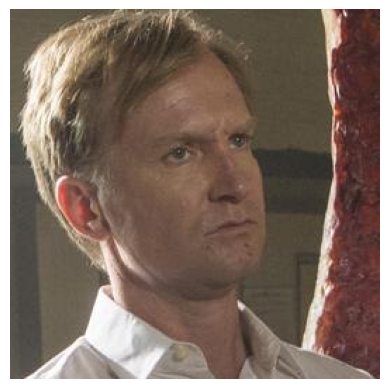

In [8]:
from PIL import Image
image_path = filter_df['image_path'][0] # acessing image
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

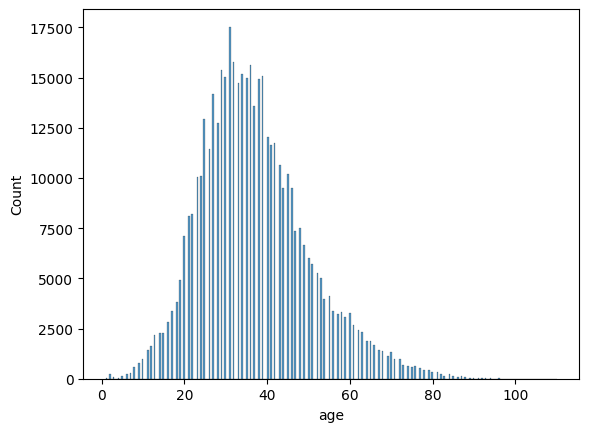

In [9]:
sns.histplot(filter_df['age']); # plotting ages

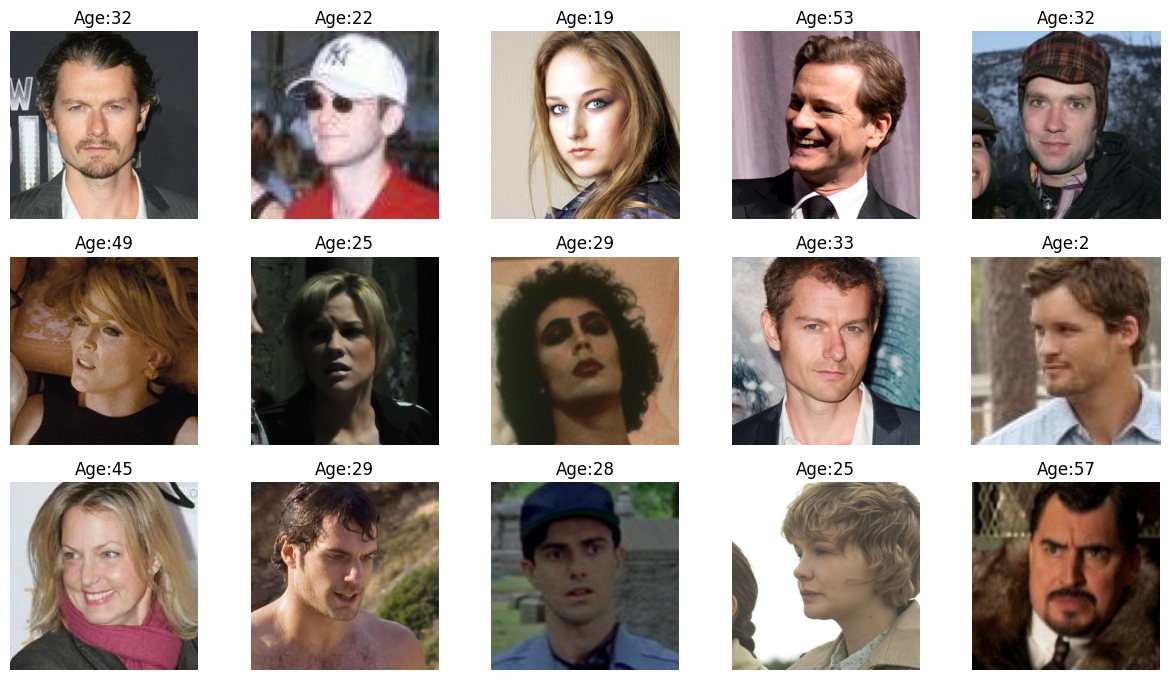

In [10]:
plt.figure(figsize = (15,20)) # setting up plot size
files = filter_df.iloc[203:218] # selecting range of files

for each, (index, file, age) in enumerate(files.itertuples(), start=1):# Iterate over files and display them in the plot
    plt.subplot(7,5,each) # use each to plce image
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f'Age:{age}')
    plt.axis('off')
plt.show()

In [11]:
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image)  # Load the image (default: RGB)
        img = img.resize((224, 224), Image.LANCZOS)  # Resize the image to 224x224
        img = np.array(img)  # Convert the image to a numpy array

        # Ensure the image has 3 channels (RGB)
        if img.ndim == 2:  # Grayscale image
            img = np.stack([img] * 3, axis=-1)  # Convert to RGB by duplicating channels

        features.append(img)

    features = np.array(features, dtype='float32')  # Convert to numpy array
    return features


In [12]:
if 'image_path' in filter_df.columns: # checking filter df has the image path column
    image_paths = filter_df['image_path'][0:10000].tolist() # convert 30000 samples to list for processing
    X = extract_features(image_paths)

else:
    print('Error : image path column is missing in filter_df')
    

100%|██████████| 10000/10000 [01:27<00:00, 114.87it/s]


In [13]:
print(X.shape)
X = X/255.0

(10000, 224, 224, 3)


In [14]:
y = filter_df['age'][0:10000] # defining labels
y = np.array(y) # converting into numpy arrays

In [15]:
from sklearn.model_selection import train_test_split # splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 85)

In [16]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [17]:
X_train.shape, y_train.shape
X_test.shape, y_test.shape

((2000, 224, 224, 3), (2000, 1))

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

#layers for regression
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='linear')(x)  # Linear activation for regression

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error', metrics=['mae'])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_vgg16_age_model.keras', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Mean Absolute Error: {mae}")

# Save the final model
#model.save('vgg16_age_prediction_model_final.h5')


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 61s 190ms/step - loss: 283.1952 - mae: 12.7848 - val_loss: 169.9888 - val_mae: 9.9860
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 156ms/step - loss: 167.7055 - mae: 10.0127 - val_loss: 162.9089 - val_mae: 9.8350
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - loss: 164.4057 - mae: 9.8620 - val_loss: 161.8461 - val_mae: 9.9338
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - loss: 149.9113 - mae: 9.4292 - val_loss: 160.0617 - val_mae: 9.6750
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 168ms/step - loss: 138.2457 - mae: 9.0316 - val_loss: 159.9092 - val_mae: 9.5986
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - loss: 133.2199 - mae: 8.8467 - val_loss: 159.7126 - val_mae: 9.5813
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - loss: 132.8450 - mae: 8.7756 - val_loss: 159.1224 - val_mae: 9.6000
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - loss: 126.7353 

Original age: 28
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted age: 29


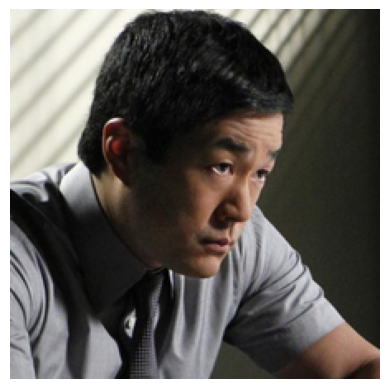

In [26]:
# Testing Image

image_index = 912 # image index to visualize

actual_age = filter_df.iloc[image_index]['age'] # orignal age
print('Original age:', actual_age)

pred = model.predict(X[image_index].reshape( 1,224, 224,3)) # predicted age

pred_age = round(pred[0][0]) # Round the predicted age to the nearest integer

print('Predicted age:', pred_age)

# Display the image
plt.imshow(X[image_index].reshape(224, 224, 3))
plt.axis('off')
plt.show()


Original age: 37
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted age: 40


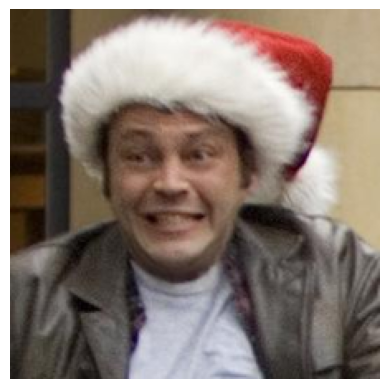

In [31]:
# Testing Image

image_index = 7677 # image index to visualize

actual_age = filter_df.iloc[image_index]['age'] # orignal age
print('Original age:', actual_age)

pred = model.predict(X[image_index].reshape( 1,224, 224,3)) # predicted age

pred_age = round(pred[0][0]) # Round the predicted age to the nearest integer

print('Predicted age:', pred_age)

# Display the image
plt.imshow(X[image_index].reshape(224, 224, 3))
plt.axis('off')
plt.show()
